# Import and load Detectron2 and libraries

In [2]:
#%env CUDA_DEVICE_ORDER=PCI_BUS_ID
#%env CUDA_VISIBLE_DEVICES={2,3}
import torch, torchvision
torch.cuda.set_device(0)

In [2]:
# Extra checks.
from torch.utils.cpp_extension import CUDA_HOME; print(torch.cuda.is_available(), CUDA_HOME)
print(torch.version.cuda)
print(torch.__version__)

True /usr/local/cuda
10.1
1.4.0


In [3]:
from torch.utils.cpp_extension import CUDA_HOME; print(torch.cuda.is_available(), CUDA_HOME)

True /usr/local/cuda


In [30]:
!nvidia-smi

Fri May 22 10:44:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:04:00.0 Off |                  N/A |
| 22%   29C    P8    16W / 250W |   4217MiB / 12212MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 980 Ti  Off  | 00000000:05:00.0 Off |                  N/A |
| 22%   30C    P8    14W / 250W |   6016MiB /  6083MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   2  G

In [4]:
%load_ext autoreload
%autoreload 2
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from operator import itemgetter

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt

Register the dataset to detectron2, following the detectron2 custom dataset tutorial. Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.

If your dataset is already in the COCO format, you can simply register it by

from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset", {}, "json_annotation.json", "path/to/image/dir")




# Load and inspect our data

In [5]:
import os
import numpy as np
import pickle
from detectron2.structures import BoxMode

def get_lofar_dicts(annotation_filepath):
    with open(annotation_filepath, "rb") as f:
        dataset_dicts = pickle.load(f)
    new_data =[]
    for i in range(len(dataset_dicts)):
        for ob in dataset_dicts[i]['annotations']:
            ob['bbox_mode'] = BoxMode.XYXY_ABS
        if dataset_dicts[i]['file_name'].endswith('_rotated0deg.png'):
            new_data.append(dataset_dicts[i])
    return new_data

DATASET_NAME= "auke_set_11"
base_path = f"/data/s1594443/data/frcnn_images_DR1/auke_set_11/LGZ_COCOstyle/annotations/"

In [6]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val", "test"]:
    DatasetCatalog.register(f"{DATASET_NAME}_" + d, 
                            lambda d=d: get_lofar_dicts(os.path.join(base_path,f"VIA_json_{d}.pkl")))
    MetadataCatalog.get(f"{DATASET_NAME}_" + d).set(thing_classes=["radio_source"])
lofar_metadata = MetadataCatalog.get(f"{DATASET_NAME}_train")

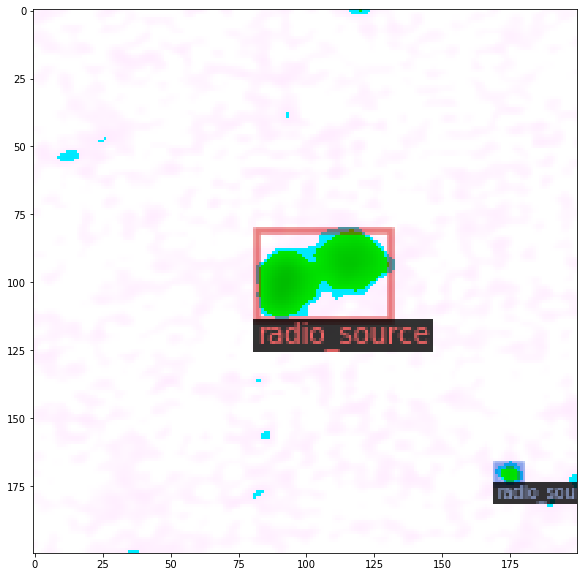

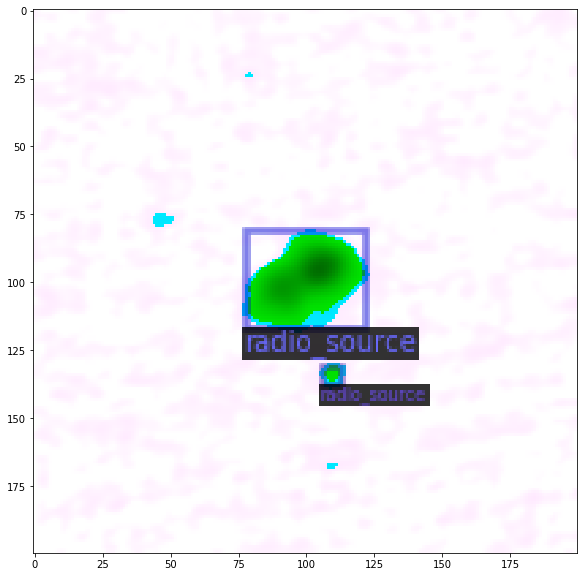

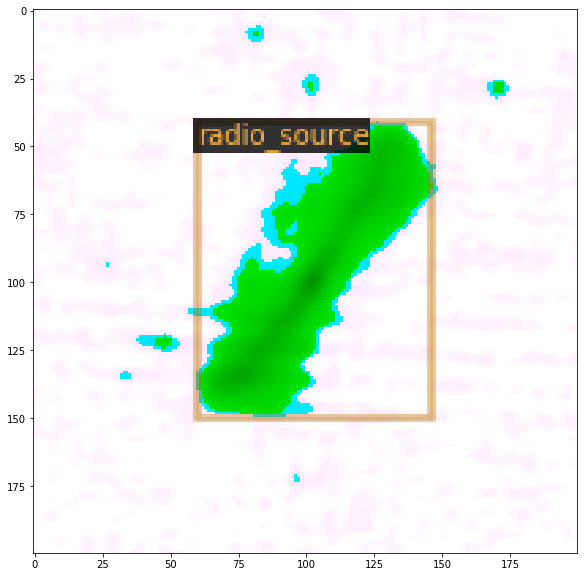

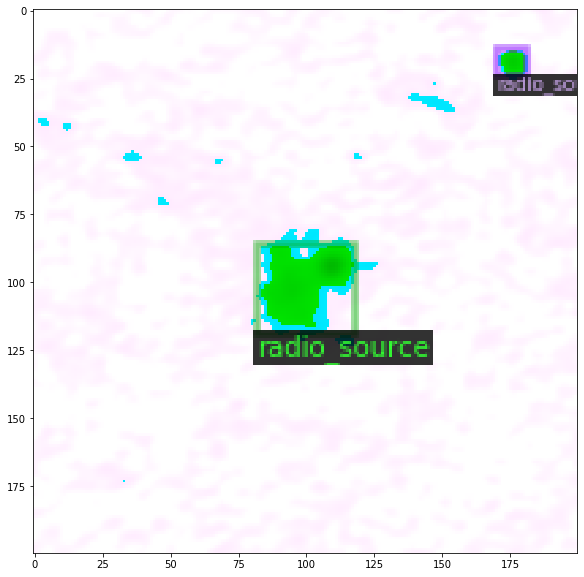

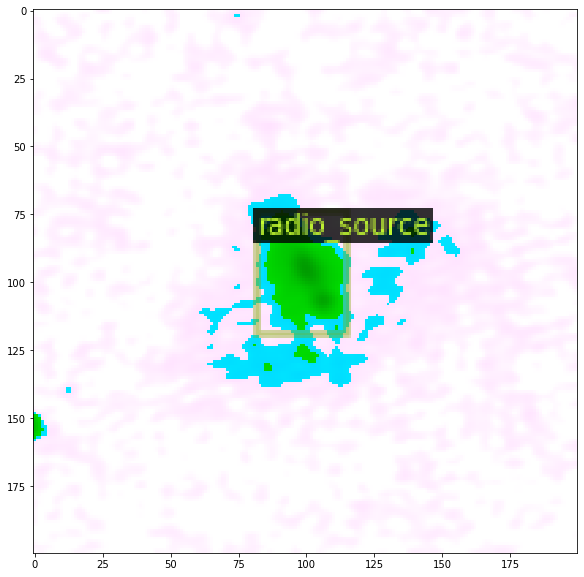

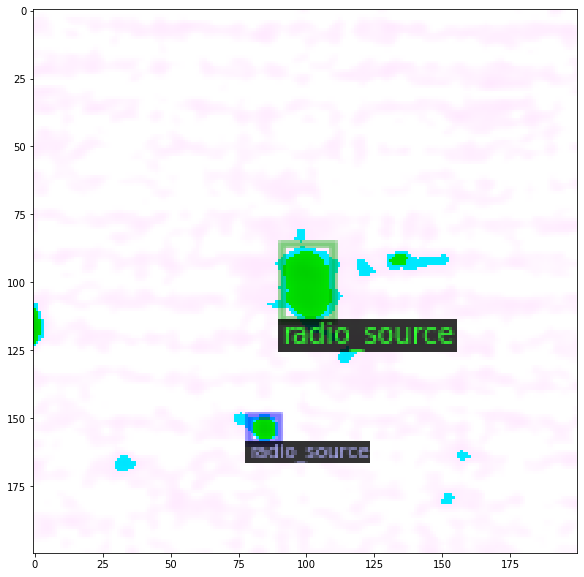

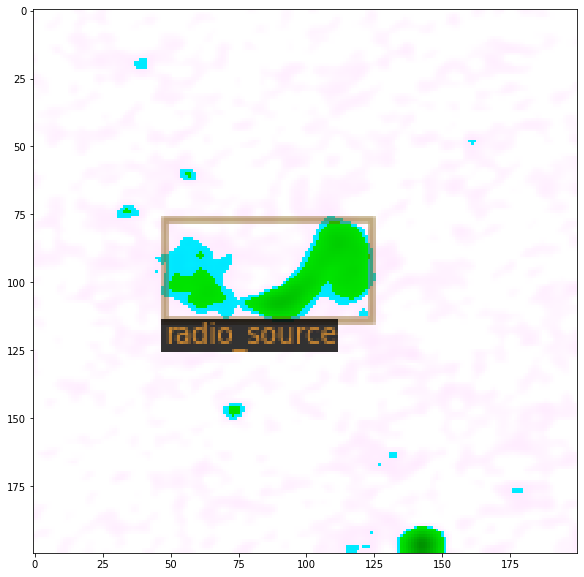

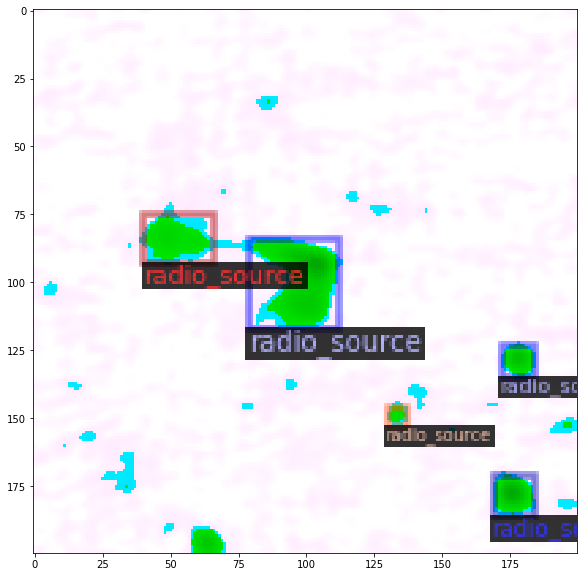

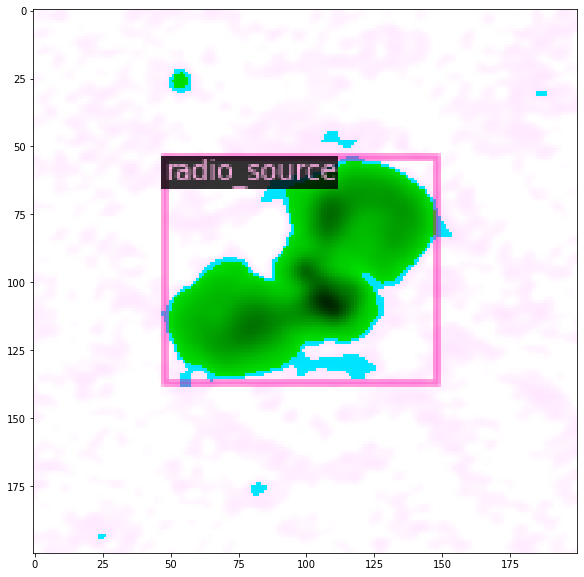

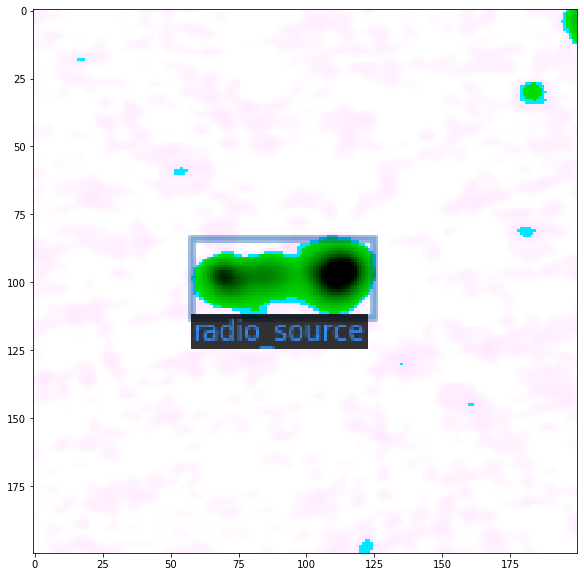

In [7]:
dataset_dicts = get_lofar_dicts(os.path.join(base_path,"VIA_json_test.pkl"))
for d in random.sample(dataset_dicts, 10):
#for d in dataset_dicts[:10]:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=lofar_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    a= vis.get_image()[:, :, ::-1]
    plt.figure(figsize=(10,10))
    plt.imshow(a)
    plt.show()

# Train mode

To implement the LOFAR relevant metrics I changed
DefaultTrainer into LOFARTrainer
where the latter calls LOFAREvaluator within build_hooks instead of the default evaluator
this works for the after the fact test eval
for train eval those things are somewhere within a model 
specifically a model that takes data and retuns a dict of losses

In [8]:
from detectron2.engine import DefaultTrainer, LOFARTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/v8_faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_train",)
cfg.DATASETS.VAL = (f"{DATASET_NAME}_val",)
cfg.DATASETS.TEST = (f"{DATASET_NAME}_test",)
cfg.DATALOADER.NUM_WORKERS = 1
cfg.OUTPUT_DIR = './output/v9'
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = None #"https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl"
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR,"model_0014999.pth")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0003  # pick a good LR
cfg.SOLVER.MAX_ITER = 100 # iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)
print(cfg.OUTPUT_DIR)

./output/v9


In [9]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = LOFARTrainer(cfg) 
trainer.resume_or_load(resume=False)

[05/21 09:29:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[05/21 09:29:04 d2.data.build]: Removed 0 images with no usable annotations. 55 images left.
[05/21 09:29:04 d2.data.build]: Distribution of instances among all 1 categories:
|   category   | #instances   |
|:------------:|:-------------|
| radio_source | 103          |
|              |              |
[05/21 09:29:04 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(600,), max_size=600, sample_style='choice'), RandomFlip()]
[05/21 09:29:04 d2.data.build]: Using training sampler TrainingSampler


In [10]:
trainer.train()

[05/21 09:29:55 d2.engine.train_loop]: Starting training from iteration 0
[05/21 09:30:13 d2.utils.events]: eta: 0:01:08  iter: 19  total_loss: 1.868  loss_cls: 0.270  loss_box_reg: 0.008  loss_rpn_cls: 0.826  loss_rpn_loc: 0.664  time: 0.8432  data_time: 0.0450  lr: 0.000006  max_mem: 3441M
[05/21 09:30:30 d2.utils.events]: eta: 0:00:51  iter: 39  total_loss: 0.761  loss_cls: 0.139  loss_box_reg: 0.004  loss_rpn_cls: 0.198  loss_rpn_loc: 0.309  time: 0.8414  data_time: 0.0089  lr: 0.000012  max_mem: 3441M
[05/21 09:30:47 d2.utils.events]: eta: 0:00:34  iter: 59  total_loss: 0.377  loss_cls: 0.119  loss_box_reg: 0.017  loss_rpn_cls: 0.128  loss_rpn_loc: 0.061  time: 0.8449  data_time: 0.0076  lr: 0.000018  max_mem: 3441M
[05/21 09:31:04 d2.utils.events]: eta: 0:00:17  iter: 79  total_loss: 0.235  loss_cls: 0.050  loss_box_reg: 0.024  loss_rpn_cls: 0.105  loss_rpn_loc: 0.048  time: 0.8483  data_time: 0.0090  lr: 0.000024  max_mem: 3441M
WARNING [05/21 09:31:22 d2.evaluation.lofar_evalua

OrderedDict([('bbox',
              {'assoc_single_fail_fraction': 0.0,
               'assoc_multi_fail_fraction': 0.25,
               'unassoc_single_fail_fraction': 0.1875,
               'unassoc_multi_fail_fraction': 0.0})])

# Inference mode

In [11]:
print(cfg.OUTPUT_DIR)

./output/v9


In [12]:
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0014999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set the testing threshold for this model
#cfg.DATASETS.TEST = (f"{DATASET_NAME}_", )
predictor = DefaultPredictor(cfg)

(200, 200, 3)
Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


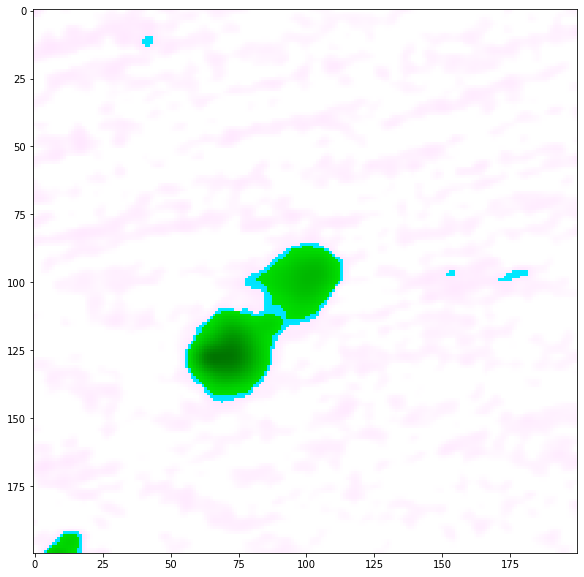

(200, 200, 3)
Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


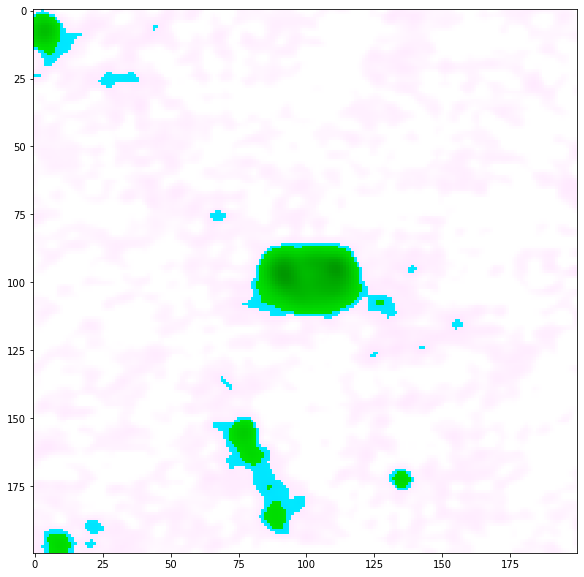

(200, 200, 3)
Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


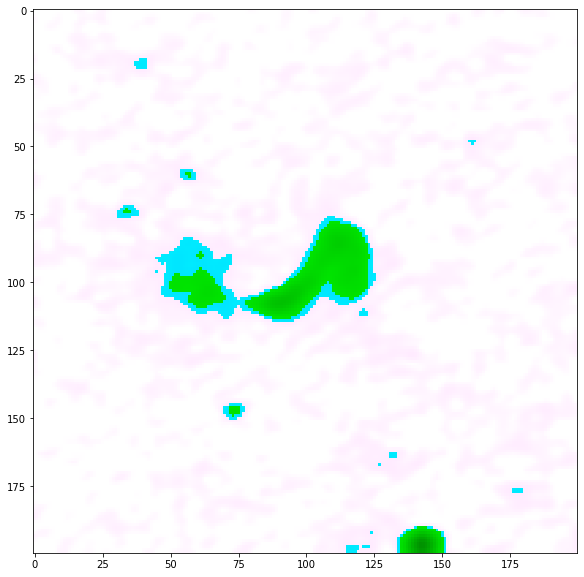

(200, 200, 3)
Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


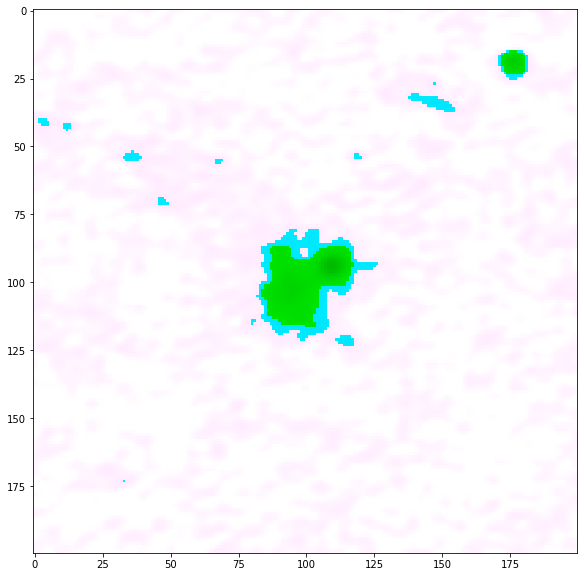

(200, 200, 3)
Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


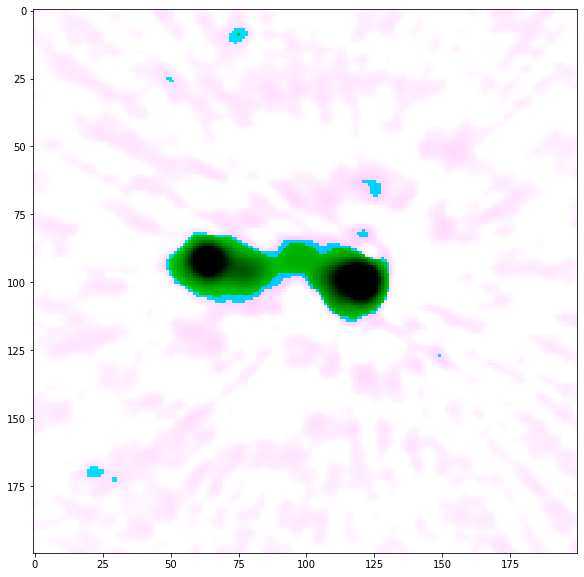

(200, 200, 3)
Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


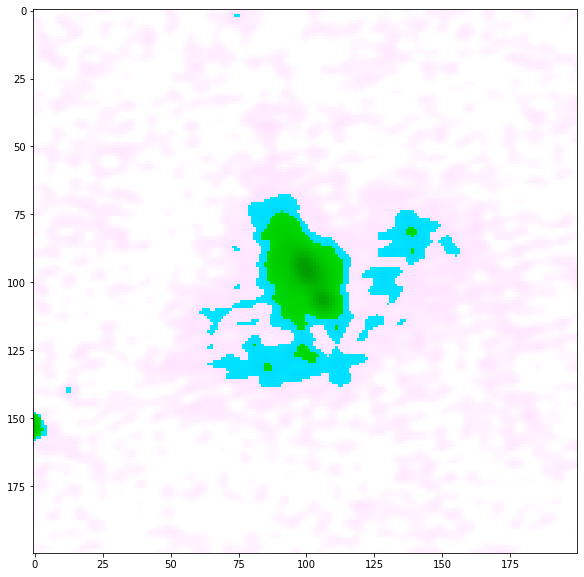

(200, 200, 3)
Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


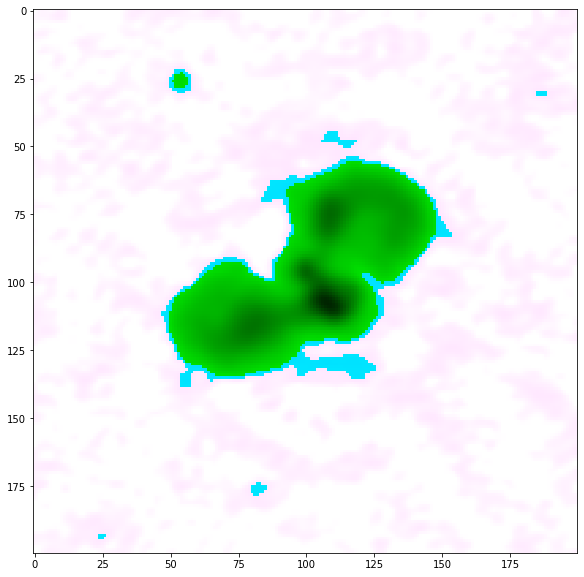

(200, 200, 3)
Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


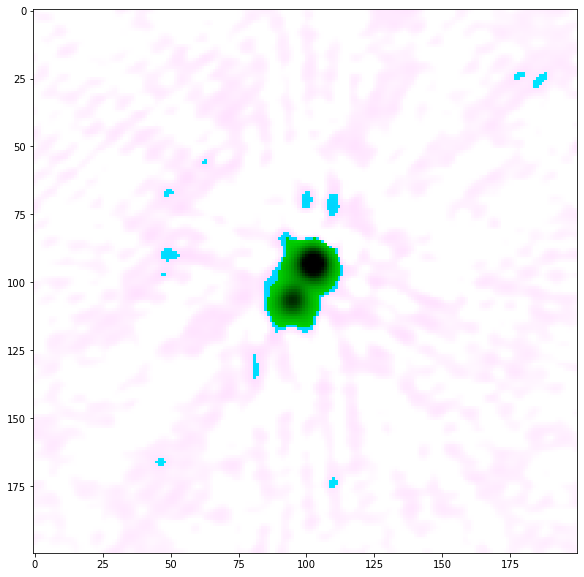

(200, 200, 3)
Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


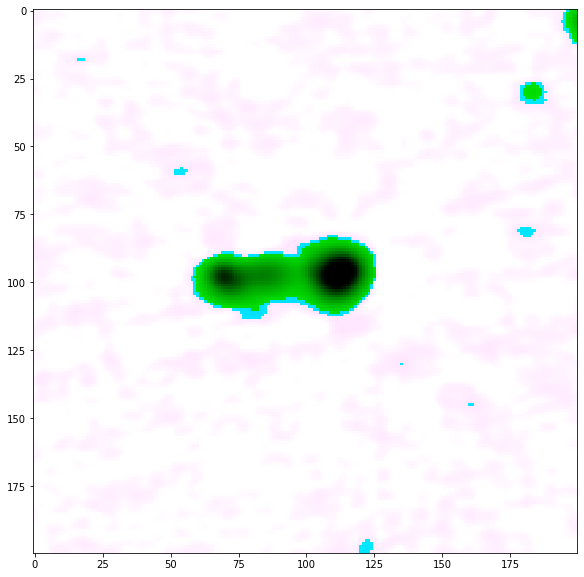

(200, 200, 3)
Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


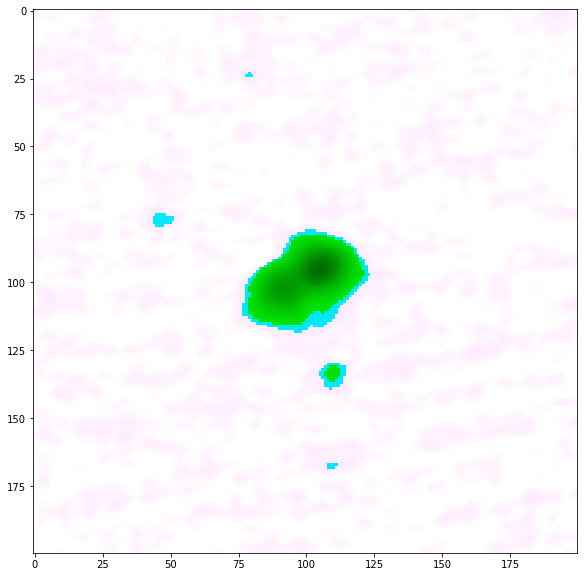

(200, 200, 3)
Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


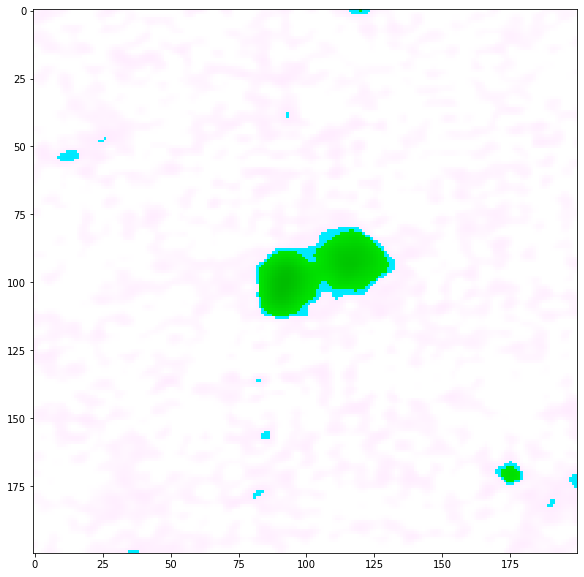

In [13]:
from detectron2.utils.visualizer import ColorMode
random.seed(5455)
aap = get_lofar_dicts(os.path.join(base_path,f"VIA_json_test.pkl"))
#for d in random.sample(aap, 30):
for i, d in enumerate(aap):
    if i > 10:
        break
    #print(d["file_name"])
    if not d["file_name"].endswith('_rotated0deg.png'):
        continue
    im = cv2.imread(d["file_name"])
    print(np.shape(im))
    outputs = predictor(im)
    print(outputs["instances"])
    v = Visualizer(im[:, :, ::-1],
                   metadata=lofar_metadata,
                   scale=1,
                  instance_mode=ColorMode.IMAGE #_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(10,10))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

In [14]:
len(os.listdir(val_image_dir)) # Apparently this directory is supposed not to exist.

NameError: name 'val_image_dir' is not defined

In [25]:
#Val set evaluation
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LOFAREvaluator
from detectron2.data import build_detection_test_loader

# returns a torch DataLoader, that loads the given detection dataset, 
# with test-time transformation and batching.
val_loader = build_detection_test_loader(cfg, f"{DATASET_NAME}_val")

#evaluator = COCOEvaluator("lofar_data1_val", cfg, False, output_dir="./output/")
my_dataset = get_lofar_dicts(os.path.join(base_path,f"VIA_json_val.pkl"))

imsize = 200
evaluator = LOFAREvaluator(f"{DATASET_NAME}_val", cfg, False,imsize, gt_data=None#, overwrite=True)
            
# Val_loader produces inputs that can enter the model for inference, 
# the results of which can be evaluated by the evaluator
# The return value is that which is returned by evaluator.evaluate()
predictions = inference_on_dataset(trainer.model, val_loader, evaluator, overwrite=False)

# Create evaluator
#1.28, 70.44, 8.83, 5.84
#1.16, 69.71, 9.64, 6.93

TypeError: __init__() got multiple values for argument 'overwrite'

In [26]:
#Test set evaluation
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LOFAREvaluator
from detectron2.data import build_detection_test_loader

# returns a torch DataLoader, that loads the given detection dataset, 
# with test-time transformation and batching.
test_loader = build_detection_test_loader(cfg, f"{DATASET_NAME}_test")

#evaluator = COCOEvaluator("lofar_data1_val", cfg, False, output_dir="./output/")
my_dataset = get_lofar_dicts(os.path.join(base_path,f"VIA_json_test.pkl"))
imsize = 200
evaluator = LOFAREvaluator(f"{DATASET_NAME}_test", cfg, False, imsize, gt_data=None)#, overwrite=False)
# In the line above I commented the overwrite part. Don't really understand yet why it solves to problem.
            
# Val_loader produces inputs that can enter the model for inference, 
# the results of which can be evaluated by the evaluator
# The return value is that which is returned by evaluator.evaluate()
predictions = inference_on_dataset(trainer.model, test_loader, evaluator, overwrite=False)

# Create evaluator

[05/21 10:06:51 d2.evaluation.evaluator]: Start inference on 20 images
./output/v9/predictions_auke_set_11_test.pkl
scale_factor 1.5151515151515151
check for dups 20 20 20
There are 16 single component sources and 4 multi.
Thus 80% of the dataset is single component.
source_names val_fits_path
ILTJ135702.90+491909.7 /data/mostertrij/data/frcnn_images/cutouts/ILTJ135702.90+491909.7_radio_DR2.fits
['ILTJ135702.90+491909.7' 'ILTJ135704.87+494918.6'
 'ILTJ140004.57+493655.1' 'ILTJ140203.08+502240.7'
 'ILTJ140204.15+513442.2' 'ILTJ140220.78+515605.8'
 'ILTJ140244.60+510347.4' 'ILTJ140331.17+510540.8'
 'ILTJ140725.27+500633.2' 'ILTJ140726.40+490731.0']
ncomps locs, centrallocs, closecomplocs
2 (array([67.20009656, 47.44207002]), array([67.15058193, 48.42235783])) (array(67.20009656), array(67.15058193)) (array([123.68297255,  63.96327811,  34.31174643,  23.52450799,
        20.46507539,   6.1390105 ]), array([-12.17298681, 162.44179201, -49.62448561, -34.03288174,
       -48.95093788,  -1.58

In [27]:
Test
OrderedDict([('bbox', {'assoc_single_fail_fraction': 0.04367816091954024, 'assoc_multi_fail_fraction': 0.46006389776357826, 'unassoc_single_fail_fraction': 0.096551724137931, 'unassoc_multi_fail_fraction': 0.07987220447284349})])
OrderedDict([('bbox', {'assoc_single_fail_fraction': 0.04367816091954024, 'assoc_multi_fail_fraction': 0.46006389776357826, 'unassoc_single_fail_fraction': 0.096551724137931, 'unassoc_multi_fail_fraction': 0.07987220447284349})])
OrderedDict([('bbox', {'assoc_single_fail_fraction': 0.04367816091954024, 'assoc_multi_fail_fraction': 0.46006389776357826, 'unassoc_single_fail_fraction': 0.096551724137931, 'unassoc_multi_fail_fraction': 0.07987220447284349})])
{'assoc_single_fail_fraction': 0.005747126436781658, 'assoc_multi_fail_fraction': 0.30351437699680506, 'unassoc_single_fail_fraction': 0.08160919540229883, 'unassoc_multi_fail_fraction': 0.11182108626198084}
val
OrderedDict([('bbox', {'assoc_single_fail_fraction': 0.03948896631823462, 'assoc_multi_fail_fraction': 0.452887537993921, 'unassoc_single_fail_fraction': 0.08710801393728218, 'unassoc_multi_fail_fraction': 0.0820668693009119})])

NameError: name 'Test' is not defined

In [28]:
[02/06 12:37:20 d2.evaluation.evaluator]: LOFAR Evaluation metrics (for all values 0% is best, 100% is worst):
[02/06 12:37:20 d2.evaluation.evaluator]: 1. Fraction of predictions that fail to cover a single component source.
[02/06 12:37:20 d2.evaluation.evaluator]: 0.23%
[02/06 12:37:20 d2.evaluation.evaluator]: 2. Fraction of predictions that fail to cover all components of a multi-component source.
[02/06 12:37:20 d2.evaluation.evaluator]: 28.57%
[02/06 12:37:20 d2.evaluation.evaluator]: 3. Fraction of predictions that include unassociated components for a single component source.
[02/06 12:37:20 d2.evaluation.evaluator]: 10.75%
[02/06 12:37:20 d2.evaluation.evaluator]: 4. Fraction of predictions that include unassociated components for a multi-component source.
[02/06 12:37:20 d2.evaluation.evaluator]: 10.96%

SyntaxError: invalid token (<ipython-input-28-0f63430e7f13>, line 1)

In [29]:
def baseline(single, multi):
    total = single + multi
    correct = single/total
    print(f"Baseline assumption cat is {correct:.1%} correct")
    return correct

def our_score(single, multi,score_dict, suffix=''):
    fail_single = score_dict['assoc_single_fail_fraction']*single + score_dict['unassoc_single_fail_fraction']*single
    fail_multi = score_dict['assoc_multi_fail_fraction']*multi + score_dict['unassoc_multi_fail_fraction']*multi
    total = single + multi
    correct = (total-(fail_single+fail_multi))/total
    print(correct)

    print(f"{suffix} cat is {correct:.1%} correct")
    return correct
def improv(baseline, our_score):
    print(f"{(our_score-baseline)/baseline:.2%} improvement")
    
test_score_dict = {'assoc_single_fail_fraction': 0.0012224938875305957, 'assoc_multi_fail_fraction': 0.3433242506811989, 
                   'unassoc_single_fail_fraction': 0.1136919315403423, 'unassoc_multi_fail_fraction': 0.10899182561307907}
test_norot_score_dict = {'assoc_single_fail_fraction': 0.005747126436781658, 'assoc_multi_fail_fraction': 0.30351437699680506, 
 'unassoc_single_fail_fraction': 0.08160919540229883, 'unassoc_multi_fail_fraction': 0.11182108626198084}
test_norot2 = {'assoc_single_fail_fraction': 0.0034482758620689724, 'assoc_multi_fail_fraction': 0.20127795527156545,
               'unassoc_single_fail_fraction': 0.11264367816091958, 'unassoc_multi_fail_fraction': 0.13418530351437696}
test_rot_score_dict = {'assoc_single_fail_fraction': 0.0045977011494252595, 'assoc_multi_fail_fraction': 0.207667731629393, 
                    'unassoc_single_fail_fraction': 0.10919540229885061, 'unassoc_multi_fail_fraction': 0.12779552715654952}
test_v7 = {'assoc_single_fail_fraction': 0.0034482758620689724, 'assoc_multi_fail_fraction': 0.20127795527156545,
 'unassoc_single_fail_fraction': 0.11264367816091958, 'unassoc_multi_fail_fraction': 0.13418530351437696}
optimal_score_dict = {'assoc_single_fail_fraction': 0.0, 'assoc_multi_fail_fraction': 0.04792332268370603, 
                   'unassoc_single_fail_fraction': 0.07241379310344831, 'unassoc_multi_fail_fraction': 0.12460063897763574}

single, multi = 870,313
baseline = baseline(single, multi)
optimal_score = our_score(single, multi, optimal_score_dict, suffix='optimal test')
our_score1 = our_score(single, multi,test_score_dict,suffix='our test')
our_score2 = our_score(single, multi,test_norot_score_dict,suffix='our new test norot')
our_score3 = our_score(single, multi,test_rot_score_dict,suffix='our new test rot')
our_score4 = our_score(single, multi,test_v7,suffix='our test v7')
improv(baseline, our_score1)
improv(baseline, our_score2)
improv(baseline, our_score3)
improv(baseline, our_score4)

Baseline assumption cat is 73.5% correct
0.9010989010989011
optimal test cat is 90.1% correct
0.7958153152980909
our test cat is 79.6% correct
0.8258664412510567
our new test norot cat is 82.6% correct
0.8275570583262891
our new test rot cat is 82.8% correct
0.8258664412510567
our test v7 cat is 82.6% correct
8.21% improvement
12.30% improvement
12.53% improvement
12.30% improvement
